In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import string
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm_notebook


from scipy.sparse import coo_matrix, hstack

In [2]:
SEED = 42

In [3]:
DATA_PATH = './data'

**[Kaggle InClass: Language Detection](https://www.kaggle.com/c/introml2020-3)**

# Exploratory Data Analysis and Metric

In [4]:
train_df = pd.read_csv(f'{DATA_PATH}/train.csv.zip')
test_df = pd.read_csv(f'{DATA_PATH}/test.csv.zip')

In [5]:
train_df.shape, test_df.shape

((3159633, 2), (2784634, 2))

In [6]:
train_df.head(15)

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
5,"Na primjer , pjesnik ga opisuje ovako .",hr
6,Semua rerumputan itu sekarang menutupi tanah s...,id
7,Det är en enorm utmaning för oss att göra det .,sv
8,Ono što ćete vidjeti - trebat ćete skočiti ovd...,hr
9,( Alqışlar ) Excel-dən istifadə etmişəm .,az


Гистограмма длины слов, видно большое количество выбросов

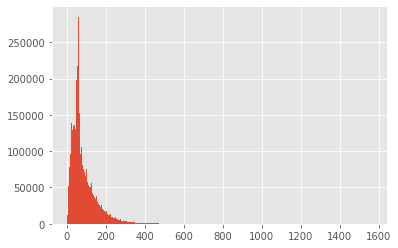

In [7]:
train_df.sentence.str.len().hist(bins=300);

Удаляем дуплирующиеся тексты

In [8]:
train_df = train_df.drop_duplicates()

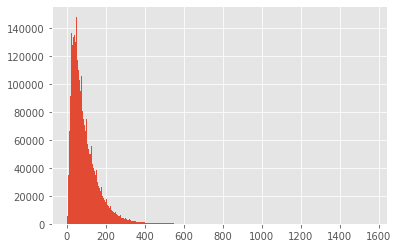

In [9]:
train_df.sentence.str.len().hist(bins=300);

Удаляем пунктуацию и числа

In [10]:
PUNCT_TO_REMOVE = string.punctuation + '1234567890«»—�'
def remove_punctuation(text):
    # заменяем пунктуацию пробелами
    text = text.translate(str.maketrans(PUNCT_TO_REMOVE, ' '*len(PUNCT_TO_REMOVE)))
    # удаляем лишние пробелы и выводим
    return " ".join(text.split())

train_df["sentence"] = train_df.sentence.apply(lambda text: remove_punctuation(text))
test_df["sentence"] = test_df.sentence.apply(lambda text: remove_punctuation(text))
train_df.shape

(2741628, 2)

Удаляем слишком короткие и слишком длинные тексты

In [11]:
train_df = train_df.loc[train_df.sentence.str.len() > 2]
train_df = train_df.loc[train_df.sentence.str.len() < 600]

Конечный вид гистограммы

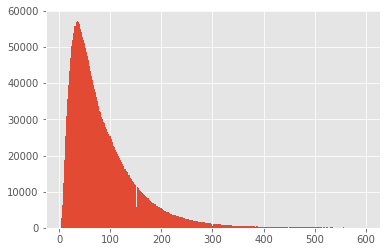

In [12]:
train_df.sentence.str.len().hist(bins=300);

In [13]:
lang_count = (
    train_df.language.value_counts()
    .to_frame()
    .reset_index()
)

lang_count.head()

,index,language
0,en,130342
1,ar,108583
2,he,106922
3,ru,105187
4,ko,103960


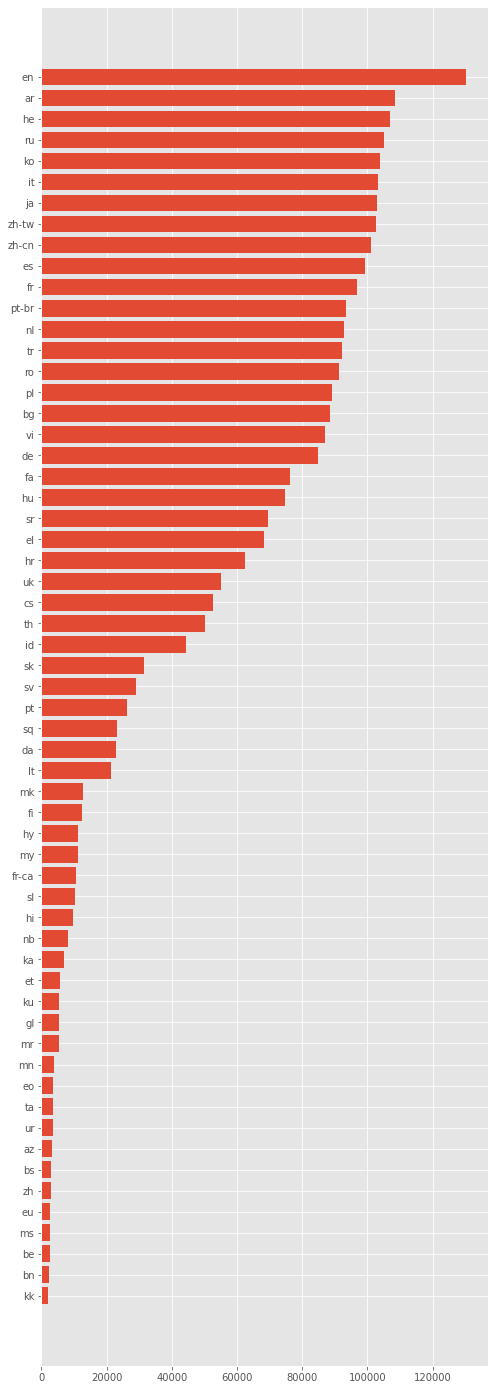

In [14]:
fig, ax = plt.subplots(figsize=(8,25))

ax.barh(lang_count['index'], lang_count['language'])
ax.invert_yaxis();

In [15]:
train_df.head(15)

,sentence,language
0,Pensez à la communication le discours les gest...,fr
1,Můžete si ji pronajmout vzít na splátky koupit...,cs
2,Každý starosta pochopil že když mají tyto form...,cs
3,Det är ytterligare bevis men ändå Jag kritiser...,sv
4,كان الأمر لا يصدق,ar
5,Na primjer pjesnik ga opisuje ovako,hr
6,Semua rerumputan itu sekarang menutupi tanah s...,id
7,Det är en enorm utmaning för oss att göra det,sv
8,Ono što ćete vidjeti trebat ćete skočiti ovdje...,hr
9,Alqışlar Excel dən istifadə etmişəm,az




**Присутствуют ошибки в разметке, так в тренировочном датасете в классе русского языка присутствует украинский язык**

In [16]:
train_df.loc[train_df['language'].values == 'ru', 'sentence']

10         После увольнения я решил собрать своих друзей ...
13         Ты знаешь что это не гнев заставил моё сердце ...
26         гэта што калі мы не яны як але ён каб дзякуй б...
40         Ради всех имён которые я никогда не узнаю назо...
91         що це тому ми чи дуже які щоб дякую якщо було ...
                                 ...                        
3159439    Так что некоторые вещи мы должны дать знать со...
3159462                            Глагол основа предложения
3159492    Примерно к ти годам они полностью покрываются ...
3159591           Некоторые действительно на грани вымирания
3159624                        Это может происходить в мозгу
Name: sentence, Length: 105187, dtype: object

# Model

In [17]:
x = train_df.values[:,  0]
label_encoder = LabelEncoder().fit(train_df.values[:, 1])
y = label_encoder.transform(train_df.values[:, 1])

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.85, test_size=0.15, random_state=SEED)

In [18]:
x_train.shape, x_test.shape

((2328614,), (410933,))

Для каждого языка определяем 50 самых повторяющихся слов по Tfidf, затем удаляем те слова, которые встречаются в других языках
В итоге получаем словарь уникальных слов для каждого языка

In [19]:
word_vectorizer = TfidfVectorizer()
imp_words = {}
languages = train_df['language'].value_counts().index.values

for language in languages:
    df_lang = train_df.loc[train_df['language'].values == language, 'sentence']
    word_vectorizer.fit(df_lang)
    features = np.array(word_vectorizer.get_feature_names())
    
    idf = pd.DataFrame({'idf':word_vectorizer.idf_, 'feature':features})
    idf = idf.sort_values(by=['idf']).head(50)
    imp_words[language] = idf['feature'].values
    
for key, val in imp_words.items():
    cache_dict = {i:imp_words[i] for i in imp_words if i!=key}
    mask = []
    for word in val:
        if not any(word in text for text in cache_dict.values()):
            mask.append(True)
        else:
            mask.append(False)
    imp_words[key] = val[mask]
    
imp_words

{'en': array(['the', 'and', 'that', 'it', 'you', 'this', 'but', 'they', 'are',
        'have', 'what', 'with', 'can', 'about', 'there', 'be', 'all',
        'not', 'one', 'people', 'my', 're', 'like', 'if', 'from', 'now',
        'just', 'these', 'when', 'our', 'because', 'or', 'out'],
       dtype=object),
 'ar': array(['في', 'أن', 'على', 'هذا', 'هذه', 'لا', 'هو', 'إلى', 'ذلك', 'التي',
        'عن', 'كان', 'كل', 'هي', 'هناك', 'الذي', 'مع', 'لم', 'أو', 'ولكن',
        'لكن', 'الآن', 'عندما', 'كانت', 'تلك', 'إذا', 'قد', 'الناس', 'فقط',
        'كنت', 'هنا', 'جدا', 'أكثر', 'أنه', 'لقد', 'يمكن', 'الى', 'ليس',
        'نحن', 'العالم', 'ضحك', 'كما', 'شيء', 'مثل', 'بعض', 'أي'],
       dtype=object),
 'he': array(['את', 'של', 'זה', 'לא', 'על', 'אני', 'הוא', 'אבל', 'אז', 'מה',
        'כל', 'עם', 'הם', 'יותר', 'היא', 'יש', 'אם', 'אנחנו', 'היה', 'או',
        'הזה', 'כך', 'אתם', 'כמו', 'אחד', 'שלנו', 'כדי', 'רק', 'שלי',
        'יכולים', 'לנו', 'להיות', 'אנשים', 'לי', 'גם', 'לעשות', 'זו',
     

Создаем новые бинарные признаки. Их количество равно количеству языков

Для каждого текста показываем, есть ли в нем хотя бы одно уникальное слово из словаря. Рассматривается первые 4 уникальных слова 

In [20]:
%%time
train_imp_word = np.zeros((x_train.shape[0],1))
test_imp_word = np.zeros((x_test.shape[0],1))

for lang, words in imp_words.items():
    print('language: ', lang)
    if lang == 'en':
        if len(words) > 4:
            i = 4
        else:
            i = len(words)
        for word in words[:i]:
            print(word)
            train_imp_word = train_imp_word + np.array([word in text.lower() for text in x_train]).reshape(-1,1)
            test_imp_word = test_imp_word + np.array([word in text.lower() for text in x_test]).reshape(-1,1)
    else:
        if len(words) > 4:
            i = 4
        else:
            i = len(words)
        train_to_stack = np.zeros((x_train.shape[0]))
        test_to_stack = np.zeros((x_test.shape[0]))
        for word in words[:i]:
            print(word)
            train_to_stack = train_to_stack + np.array([word in text.lower() for text in x_train])
            test_to_stack = test_to_stack + np.array([word in text.lower() for text in x_test])
        train_imp_word = np.hstack([train_imp_word, train_to_stack.reshape(-1,1)])
        test_imp_word = np.hstack([test_imp_word, test_to_stack.reshape(-1,1)])
        
for i in range(train_imp_word.shape[0]):
    for j in range(train_imp_word.shape[1]):
        if train_imp_word[i][j]:
            train_imp_word[i][j] = 1
for i in range(test_imp_word.shape[0]):
    for j in range(test_imp_word.shape[1]):
        if test_imp_word[i][j]:
            test_imp_word[i][j] = 1

language:  en
the
and
that
it
language:  ar
في
أن
على
هذا
language:  he
את
של
זה
לא
language:  ru
что
это
из
они
language:  ko
있습니다
그리고
저는
있는
language:  it
che
sono
questo
come
language:  ja
そして
しかし
でも
拍手
language:  zh-tw
現在
他說
謝謝
我說
language:  zh-cn
笑声
现在
掌声
事实上
language:  es
una
los
lo
las
language:  fr
bien
language:  pt-br
você
eles
vocês
bem
language:  nl
het
een
dat
ik
language:  tr
için
çok
ama
gibi
language:  ro
în
să
care
că
language:  pl
się
jest
że
tym
language:  bg
това
от
че
си
language:  vi
và
là
tôi
có
language:  de
und
die
ist
sie
language:  fa
در
می
این
از
language:  hu
és
hogy
egy
nem
language:  sr
је
то
language:  el
και
να
το
είναι
language:  hr
bio
stvari
smijeh
ono
language:  uk
що
це
вони
про
language:  cs
jsem
co
jak
jsme
language:  th
แต
เป
ได
อย
language:  id
hal
bahwa
bisa
karena
language:  sk
že
ale
čo
sme
language:  sv
och
att
är
jag
language:  pt
um
uma
não
em
language:  sq
të
dhe
në
një
language:  da
af
der
ved
hvad
language:  lt
ir
kad
yra
aš
language:  

Векторизуем тексты

In [21]:
vectorizer = CountVectorizer(analyzer='char_wb',ngram_range=(1,4), binary=True, min_df=2)
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

In [22]:
x_train_vectorized.shape

(2328614, 2764568)

Добавляем новый признак равный отношению количества слов к количеству символов

In [24]:
train_word_ratio = np.array([len(text.split())/len(text) for text in x_train])
test_word_ratio = np.array([len(text.split())/len(text) for text in x_test])

In [25]:
SGD = SGDClassifier(random_state=SEED, loss='log', n_jobs=-1, class_weight='balanced')
LGBM = LGBMClassifier(learning_rate=0.08, n_estimators=10, n_jobs=-1, class_weight='balanced')

Фитируем модели

In [26]:
# %%time
# LGBM.fit(
#     hstack([x_train_vectorized, train_word_ratio.reshape(-1,1), train_imp_word]),
#     y_train
# )

In [27]:
%%time
SGD.fit(
    hstack([x_train_vectorized, train_word_ratio.reshape(-1,1),train_imp_word]),
    y_train
)

Wall time: 10min 6s


SGDClassifier(class_weight='balanced', loss='log', n_jobs=-1, random_state=42)

In [28]:
y_pred = SGD.predict(
    hstack([x_test_vectorized, test_word_ratio.reshape(-1,1), test_imp_word]),
)

Получаем скор

In [29]:
balanced_accuracy_score(y_test, y_pred)

0.9340916974767733

In [30]:
# 0.8747481556831563
# 0.8754446520927074
# 0.8819160915547727 при 0.05 0.05
# 0.8957781518711504 при 0.25 0.15
# 0.8976523013715464 при 0.5 0.15

# 0.8773792548099905 при 0.025 0.025
# 0.8955424298187364
# 0.8962147636847603
# 0.9020634468708565 char_wb + min_df=2 + ngram_range=(1,4)

Смотрим какие языки путает классификатор. Ох уж эти славянские языки((

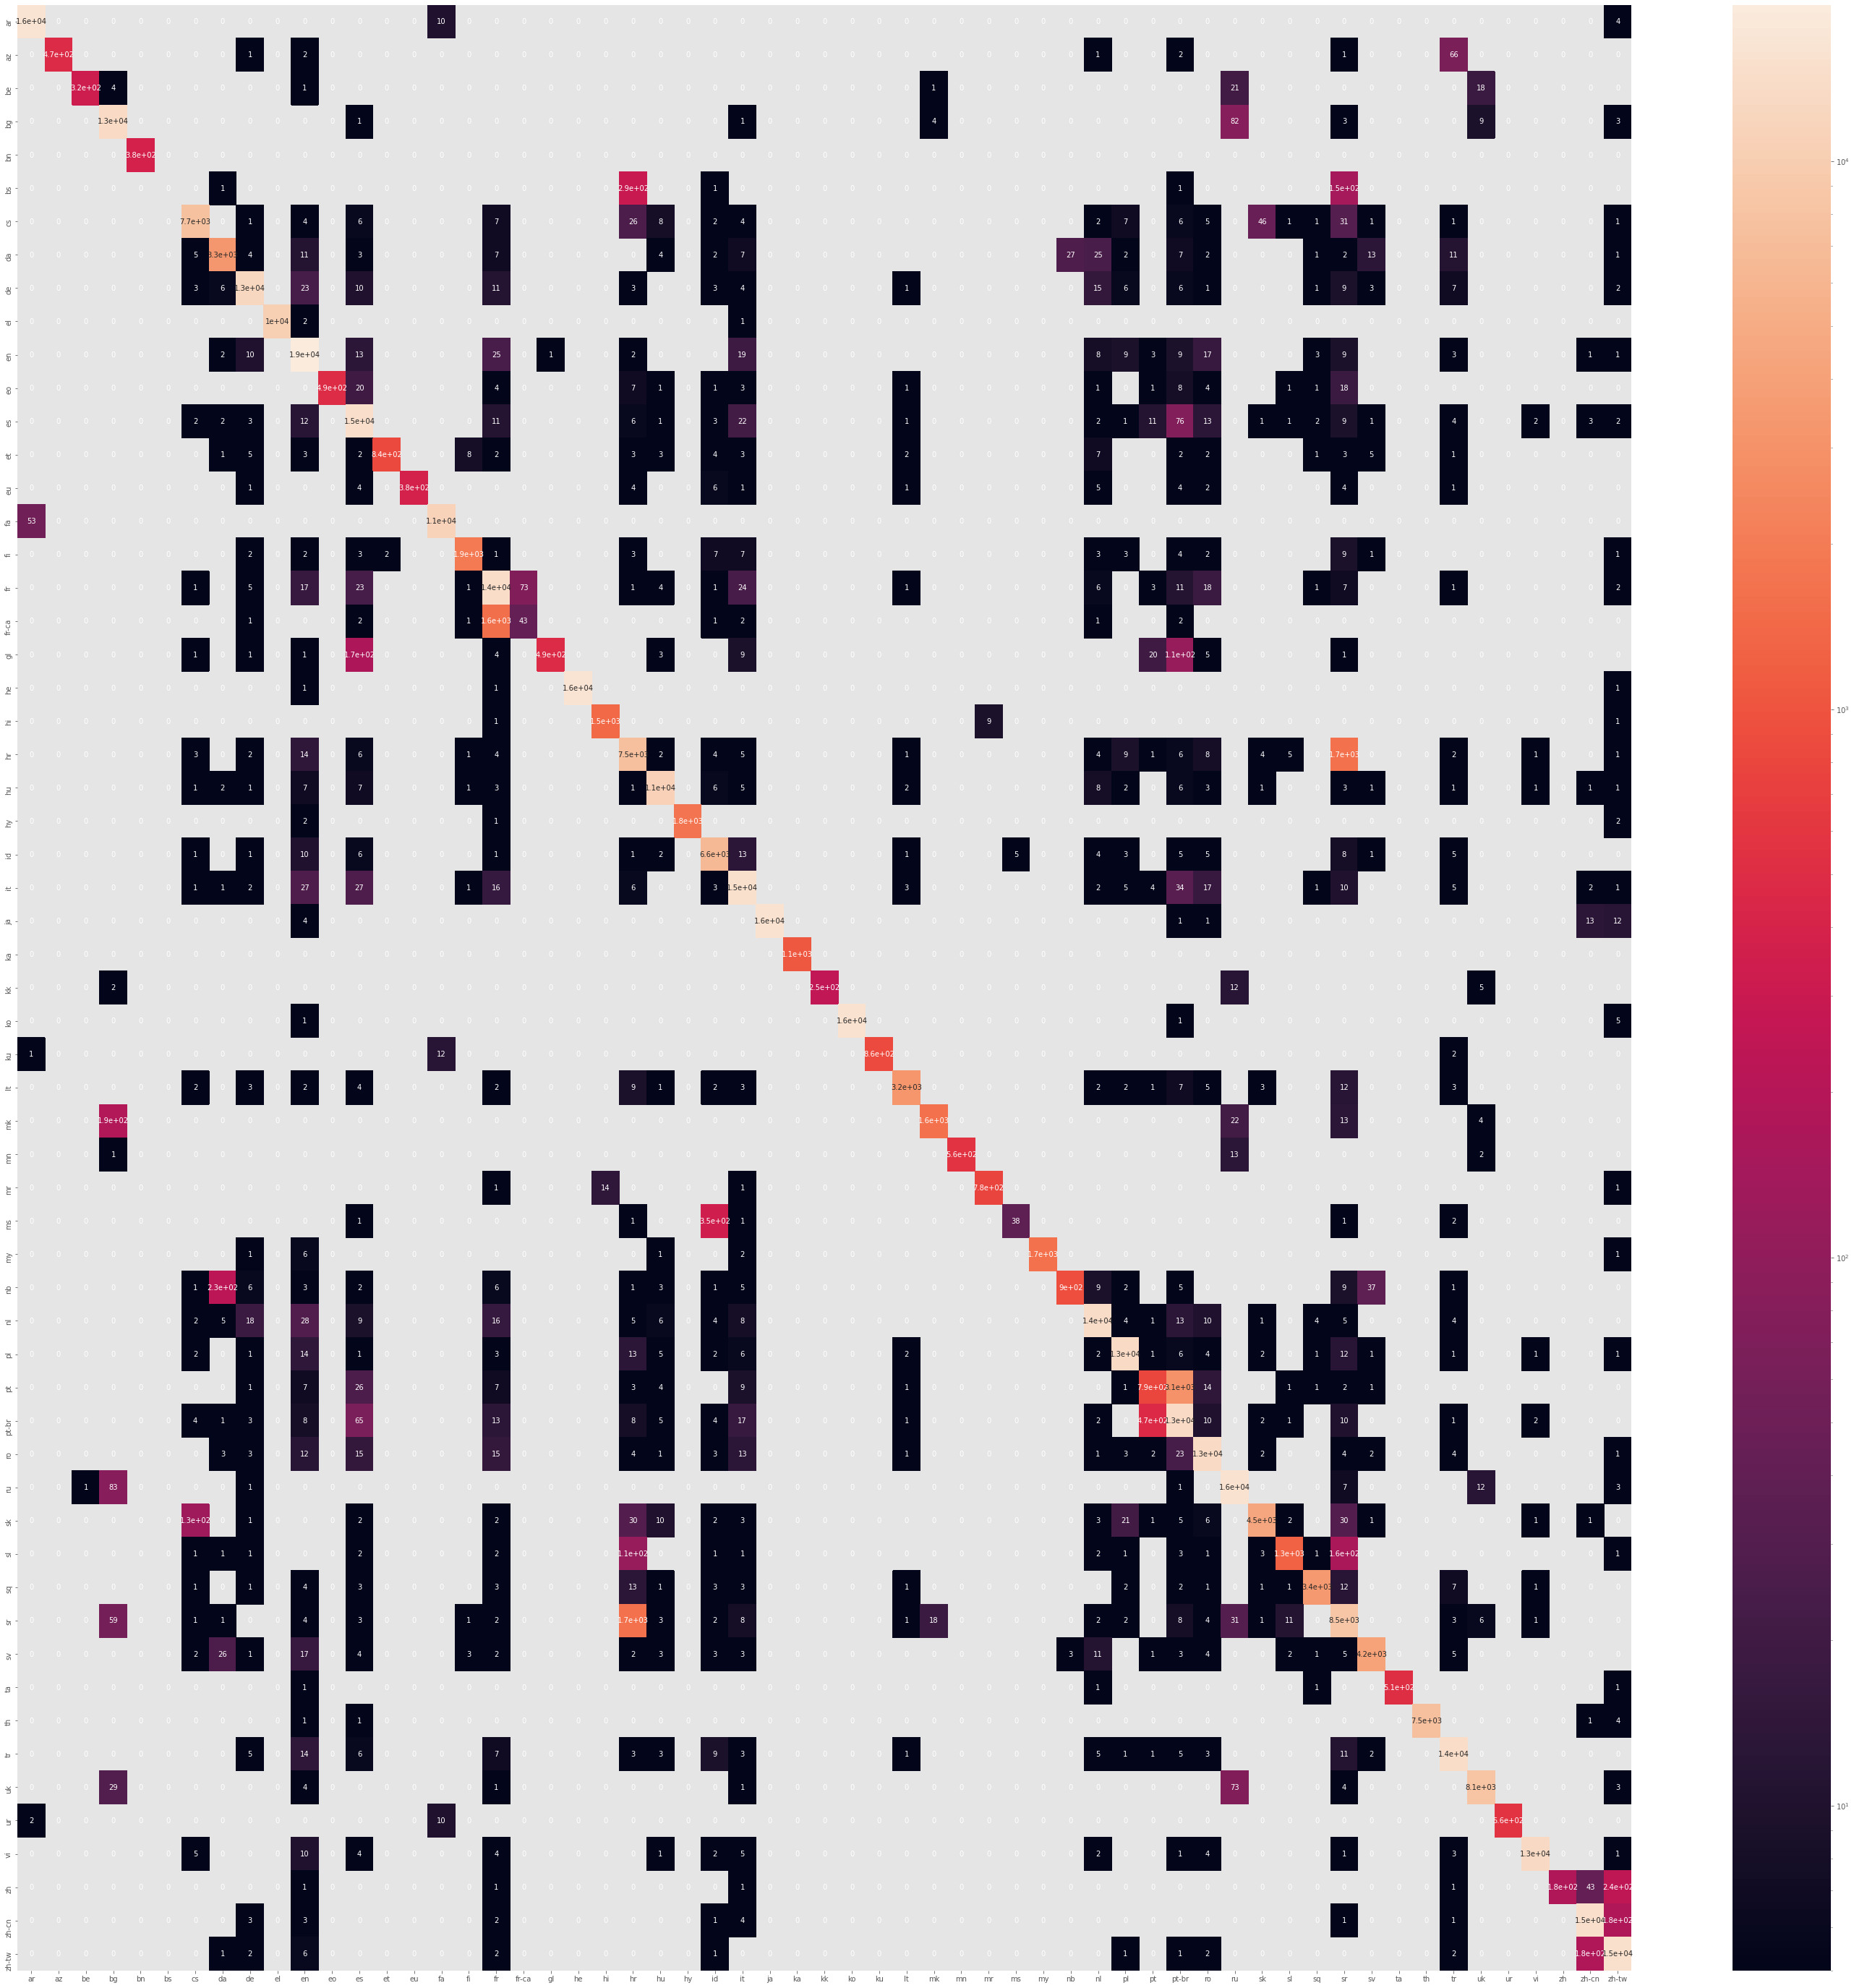

In [236]:
from matplotlib.colors import LogNorm

cm = confusion_matrix(label_encoder.classes_[y_test], label_encoder.classes_[y_pred],
                     labels=np.unique(label_encoder.classes_[y_test]))
df_cm = pd.DataFrame(cm, index=np.unique(label_encoder.classes_[y_test]),
                    columns=np.unique(label_encoder.classes_[y_test]))
log_norm = LogNorm(vmin=5, vmax=cm.max())
plt.figure(figsize = (50,50))
sn.heatmap(df_cm, annot=True, norm=log_norm)
plt.savefig('plot.png')

# Submit

In [31]:
submit_text = test_df.sentence.values
submit_word_ratio = np.array([len(text.split())/len(text) if len(text)!=0 else 0 for text in submit_text])

In [32]:
%%time
submit_imp_word = np.zeros((submit_text.shape[0],1))

for lang, words in imp_words.items():
    print('language: ', lang)
    if lang == 'en':
        if len(words) > 4:
            i = 4
        else:
            i = len(words)
        for word in words[:i]:
            print(word)
            submit_imp_word = submit_imp_word + np.array([word in text.lower() for text in submit_text]).reshape(-1,1)
    else:
        if len(words) > 4:
            i = 4
        else:
            i = len(words)
        submit_to_stack = np.zeros((submit_text.shape[0]))
        for word in words[:i]:
            print(word)
            submit_to_stack = submit_to_stack + np.array([word in text.lower() for text in submit_text])
        submit_imp_word = np.hstack([submit_imp_word, submit_to_stack.reshape(-1,1)])
        
for i in range(submit_imp_word.shape[0]):
    for j in range(submit_imp_word.shape[1]):
        if submit_imp_word[i][j]:
            submit_imp_word[i][j] = 1

language:  en
the
and
that
it
language:  ar
في
أن
على
هذا
language:  he
את
של
זה
לא
language:  ru
что
это
из
они
language:  ko
있습니다
그리고
저는
있는
language:  it
che
sono
questo
come
language:  ja
そして
しかし
でも
拍手
language:  zh-tw
現在
他說
謝謝
我說
language:  zh-cn
笑声
现在
掌声
事实上
language:  es
una
los
lo
las
language:  fr
bien
language:  pt-br
você
eles
vocês
bem
language:  nl
het
een
dat
ik
language:  tr
için
çok
ama
gibi
language:  ro
în
să
care
că
language:  pl
się
jest
że
tym
language:  bg
това
от
че
си
language:  vi
và
là
tôi
có
language:  de
und
die
ist
sie
language:  fa
در
می
این
از
language:  hu
és
hogy
egy
nem
language:  sr
је
то
language:  el
και
να
το
είναι
language:  hr
bio
stvari
smijeh
ono
language:  uk
що
це
вони
про
language:  cs
jsem
co
jak
jsme
language:  th
แต
เป
ได
อย
language:  id
hal
bahwa
bisa
karena
language:  sk
že
ale
čo
sme
language:  sv
och
att
är
jag
language:  pt
um
uma
não
em
language:  sq
të
dhe
në
një
language:  da
af
der
ved
hvad
language:  lt
ir
kad
yra
aš
language:  

In [33]:
%%time
submit_vectorized = vectorizer.transform(test_df.sentence.values)
submit_predictions = SGD.predict(
    hstack([submit_vectorized,submit_word_ratio.reshape(-1,1), submit_imp_word]),
)

Wall time: 9min 22s


In [34]:
test_df['language'] = label_encoder.classes_[submit_predictions]

test_df.head()

,index,sentence,language
0,0,תודה לכם,he
1,1,Precisamos de compaixão para começar e auto in...,pt-br
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,zh-tw
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요,ko
4,4,これをロボットに組み込みました,ja


In [35]:
(
    test_df[['index',  'language']]
    .to_csv(f'{DATA_PATH}/sample_submission.csv', index=False)
)